# A failed training without regularisation (Or why we need it)

> Here, we test a training without regularisation. The same network and dataset, with the same changes in learning rate was succesfully trained with regulariser (Observation loss reduced to around 2.0 unit). In contrast, without regularisation, practically it is impossible to train the model. These are the observation:

1) Initially the loss value reduces for a moderate learning rate. But it reaches to a plateau that after sometimes spikes start to appear in loss values, and in overal the value remains at the plateau.

2) To remedy the problem, we have to reduce the loss. However, the loss that removes the spikes (or say cuases the loss value to climb down from the plateau) is so small that the loss reduction is not practically useful, except for very very long training iteration.

In [2]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

In [3]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [4]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [5]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [6]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[-2:]
T = len(t_star)
data = data[:, :, :, -2::]

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]


In [10]:
layers = [3, 1024, 1024, 1024, 1024, 1024, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
#layers = [3, 1024, 1024, 512, 256, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID],
        b_B=df_params.bb[ID],
        b_C=df_params.bc[ID],
        b_D=df_params.bd[ID],
        b_E=df_params.be[ID],
        b_F=df_params.bf[ID],
        V_A=df_params.Va[ID],
        V_B=df_params.Vb[ID],
        V_C=df_params.Vc[ID],
        V_D=df_params.Vd[ID],
        V_E=df_params.Ve[ID],
        V_F=df_params.Vf[ID],
        k_AA=df_params.kaa[ID],
        k_BD=df_params.kbd[ID],
        k_CE=df_params.kce[ID],
        k_DA=df_params.kda[ID],
        k_EB=df_params.keb[ID],
        k_EE=df_params.kee[ID],
        k_FE=df_params.kfe[ID],
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                print_precision=".10f")

In [11]:
results = model.train(
        epochs = 100,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)

model.optimizer.lr.assign(1e-4)

results2 = model.train(
        epochs = 500,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)




Start of epoch 0
Training observations acc over epoch: 1145.0648193359
total loss: 15829.0304870605, total regularisd loss (sum of batches): 696031.7690429688
obs A loss: 4.2246743375, pde A loss: 5120.3623228073
obs B loss: 4.6927841678, pde B loss: 256.7527177765
obs C loss: 6.1464076936, pde C loss: 125.4461393282
obs D loss: 6386.1614685059, pde D loss: 2154.5577612498
obs E loss: 332.3585329056, pde E loss: 955.4344156832
obs F loss: 202.7661969662, pde F loss: 280.1267388350
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 90.77s

Start of epoch 1
Training observations acc over epoch: 1060.5767822266
total loss: 6910.3076171875, total regularisd loss (sum of batches): 304117.3178710938
obs 

Training observations acc over epoch: 644.9301147461
total loss: 4135.1134796143, total regularisd loss (sum of batches): 182020.2954101562
obs A loss: 0.5530930422, pde A loss: 10.8018799014
obs B loss: 27.8202286363, pde B loss: 15.7622132841
obs C loss: 2.1871196218, pde C loss: 1.6824504739
obs D loss: 3470.2143249512, pde D loss: 180.9030066368
obs E loss: 268.7820878029, pde E loss: 30.3622667845
obs F loss: 100.0242922306, pde F loss: 26.0204958303
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.30s

Start of epoch 11
Training observations acc over epoch: 648.1217041016
total loss: 4003.8960189819, total regularisd loss (sum of batches): 176161.0305175781
obs A loss: 1.3900408158, pde A

Training observations acc over epoch: 632.7202148438
total loss: 3811.5100784302, total regularisd loss (sum of batches): 167715.2639160156
obs A loss: 1.4185680579, pde A loss: 0.4017478712
obs B loss: 2.8467535563, pde B loss: 0.1305537321
obs C loss: 2.0705337934, pde C loss: 0.0903144925
obs D loss: 3469.5379180908, pde D loss: 3.0750740397
obs E loss: 231.7844357491, pde E loss: 10.9955764664
obs F loss: 88.6627900600, pde F loss: 0.4957725230
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 67.48s

Start of epoch 21
Training observations acc over epoch: 653.5951538086
total loss: 4327.7883377075, total regularisd loss (sum of batches): 190410.3359375000
obs A loss: 1.4412632417, pde A loss: 

Training observations acc over epoch: 633.4503784180
total loss: 3853.2257385254, total regularisd loss (sum of batches): 169538.0288085938
obs A loss: 2.8563318085, pde A loss: 2.1863525917
obs B loss: 2.6808093749, pde B loss: 6.2234320017
obs C loss: 2.1185701862, pde C loss: 0.1808684627
obs D loss: 3469.2932815552, pde D loss: 12.4946023275
obs E loss: 213.6795978546, pde E loss: 24.9297635653
obs F loss: 110.0737165213, pde F loss: 6.5083885393
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.46s

Start of epoch 31
Training observations acc over epoch: 631.3270874023
total loss: 3877.1918182373, total regularisd loss (sum of batches): 170587.1203613281
obs A loss: 2.2866909448, pde A loss

Training observations acc over epoch: 622.0767822266
total loss: 3832.0242004395, total regularisd loss (sum of batches): 168611.6000976562
obs A loss: 3.4345468581, pde A loss: 24.8401725888
obs B loss: 9.1525178403, pde B loss: 37.2629528046
obs C loss: 2.1338434033, pde C loss: 0.0779428205
obs D loss: 3460.0109100342, pde D loss: 0.4109058753
obs E loss: 204.1908745766, pde E loss: 13.2355683148
obs F loss: 53.5379432440, pde F loss: 23.7359927297
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.84s

Start of epoch 41
Training observations acc over epoch: 621.5878906250
total loss: 3827.5367889404, total regularisd loss (sum of batches): 168411.3173828125
obs A loss: 3.4744657874, pde A los

Training observations acc over epoch: 601.1765747070
total loss: 3683.4534149170, total regularisd loss (sum of batches): 162068.3398437500
obs A loss: 3.7487487905, pde A loss: 19.7934915870
obs B loss: 10.8337877840, pde B loss: 28.3120912015
obs C loss: 2.0810726564, pde C loss: 0.1108901267
obs D loss: 3346.6846618652, pde D loss: 13.7915909067
obs E loss: 190.6766581535, pde E loss: 8.5398667604
obs F loss: 53.0343676805, pde F loss: 5.8461943269
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 65.93s

Start of epoch 51
Training observations acc over epoch: 597.5546875000
total loss: 3654.6847686768, total regularisd loss (sum of batches): 160807.7480468750
obs A loss: 3.7972705811, pde A los

Training observations acc over epoch: 494.0459899902
total loss: 3135.3179855347, total regularisd loss (sum of batches): 137946.2487792969
obs A loss: 3.5292942449, pde A loss: 39.7652199864
obs B loss: 11.0368944257, pde B loss: 33.0595058799
obs C loss: 2.2296612635, pde C loss: 0.2458584027
obs D loss: 2713.5060195923, pde D loss: 61.5873399973
obs E loss: 184.8266029358, pde E loss: 20.0187915266
obs F loss: 49.1477098465, pde F loss: 16.3650676608
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.06s

Start of epoch 61
Training observations acc over epoch: 438.1401672363
total loss: 2836.1522026062, total regularisd loss (sum of batches): 124778.1816406250
obs A loss: 3.6704062149, pde A l

Training observations acc over epoch: 244.2928161621
total loss: 1727.6321830750, total regularisd loss (sum of batches): 76022.7120361328
obs A loss: 4.2152852379, pde A loss: 112.2764179707
obs B loss: 12.6138108373, pde B loss: 73.6099110246
obs C loss: 2.6168195046, pde C loss: 1.4065366480
obs D loss: 1235.3006973267, pde D loss: 44.4821424186
obs E loss: 163.2133505344, pde E loss: 15.4090081602
obs F loss: 47.7972649336, pde F loss: 14.6909370422
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.10s

Start of epoch 71
Training observations acc over epoch: 243.0135345459
total loss: 1707.2816123962, total regularisd loss (sum of batches): 75115.2344970703
obs A loss: 4.3527790867, pde A lo

Training observations acc over epoch: 248.2764892578
total loss: 1759.8759422302, total regularisd loss (sum of batches): 77428.6905517578
obs A loss: 3.4020778164, pde A loss: 123.9641950130
obs B loss: 12.5964190662, pde B loss: 72.7968094349
obs C loss: 3.2307459339, pde C loss: 0.8441131013
obs D loss: 1239.8146953583, pde D loss: 32.6207558811
obs E loss: 181.5707590580, pde E loss: 14.9237542748
obs F loss: 49.0444320440, pde F loss: 25.0671658516
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 67.50s

Start of epoch 81
Training observations acc over epoch: 230.3729705811
total loss: 1556.7029705048, total regularisd loss (sum of batches): 68494.6018066406
obs A loss: 4.2484540679, pde A lo

Training observations acc over epoch: 209.5583953857
total loss: 1413.4739398956, total regularisd loss (sum of batches): 62190.3289794922
obs A loss: 5.2280475758, pde A loss: 62.0003964901
obs B loss: 12.0952921808, pde B loss: 24.7033845782
obs C loss: 2.1101588998, pde C loss: 1.4721637368
obs D loss: 1071.3824405670, pde D loss: 49.5418102741
obs E loss: 122.7678270340, pde E loss: 14.0821017027
obs F loss: 43.7665866017, pde F loss: 4.3237289265
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.68s

Start of epoch 91
Training observations acc over epoch: 214.5519104004
total loss: 1447.5563621521, total regularisd loss (sum of batches): 63697.6517333984
obs A loss: 5.1906129457, pde A loss

Training observations acc over epoch: 251.6719818115
total loss: 1753.8895149231, total regularisd loss (sum of batches): 77166.0455322266
obs A loss: 4.2166731954, pde A loss: 91.8050742149
obs B loss: 13.3136768937, pde B loss: 71.6772925854
obs C loss: 2.8666094989, pde C loss: 1.0842846893
obs D loss: 1289.0511951447, pde D loss: 25.8084376156
obs E loss: 147.6184897423, pde E loss: 29.8232476711
obs F loss: 52.9649277925, pde F loss: 23.6596146226
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.93s

Start of epoch 1
Training observations acc over epoch: 231.8827362061
total loss: 1532.5499763489, total regularisd loss (sum of batches): 67433.8452148438
obs A loss: 4.0011344627, pde A loss

Training observations acc over epoch: 186.8585357666
total loss: 1179.7650108337, total regularisd loss (sum of batches): 51909.0634765625
obs A loss: 4.3919029608, pde A loss: 18.6664979756
obs B loss: 11.1944387257, pde B loss: 6.8801741302
obs C loss: 2.3147704639, pde C loss: 2.5032823198
obs D loss: 950.9889259338, pde D loss: 4.7737030387
obs E loss: 116.5947499275, pde E loss: 22.0547413528
obs F loss: 35.6663809419, pde F loss: 3.7354522273
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.64s

Start of epoch 11
Training observations acc over epoch: 185.5496826172
total loss: 1171.8985404968, total regularisd loss (sum of batches): 51563.4638671875
obs A loss: 4.4920257777, pde A loss: 1

Training observations acc over epoch: 179.6217041016
total loss: 1130.0256748199, total regularisd loss (sum of batches): 49726.1679077148
obs A loss: 4.8968520388, pde A loss: 17.6298200488
obs B loss: 11.0388778746, pde B loss: 6.7997896820
obs C loss: 2.1830167454, pde C loss: 2.5857592933
obs D loss: 913.7999343872, pde D loss: 3.8417031392
obs E loss: 112.8358001709, pde E loss: 19.7827449143
obs F loss: 32.9756001830, pde F loss: 1.6557647400
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.41s

Start of epoch 21
Training observations acc over epoch: 179.0033111572
total loss: 1125.1995449066, total regularisd loss (sum of batches): 49507.2661132812
obs A loss: 4.9105774090, pde A loss: 1

Training observations acc over epoch: 174.3974914551
total loss: 1089.6629447937, total regularisd loss (sum of batches): 47950.2233276367
obs A loss: 5.0090035051, pde A loss: 16.2533881068
obs B loss: 11.2387525588, pde B loss: 6.7953820229
obs C loss: 1.9397296347, pde C loss: 1.4890861586
obs D loss: 889.8789901733, pde D loss: 4.2880542837
obs E loss: 109.5173103809, pde E loss: 13.5575493574
obs F loss: 28.8012290597, pde F loss: 0.8944569500
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.76s

Start of epoch 31
Training observations acc over epoch: 173.9852142334
total loss: 1086.6128330231, total regularisd loss (sum of batches): 47817.8834838867
obs A loss: 4.9983987883, pde A loss: 1

Training observations acc over epoch: 169.9483184814
total loss: 1054.9059162140, total regularisd loss (sum of batches): 46417.9827880859
obs A loss: 4.7960465848, pde A loss: 16.6031980217
obs B loss: 11.3494672030, pde B loss: 5.8386679813
obs C loss: 1.8784512635, pde C loss: 0.8636439359
obs D loss: 870.7367420197, pde D loss: 4.1410834603
obs E loss: 107.1392612457, pde E loss: 7.0003267676
obs F loss: 23.7900462151, pde F loss: 0.7689836193
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.57s

Start of epoch 41
Training observations acc over epoch: 169.5982818604
total loss: 1050.0123596191, total regularisd loss (sum of batches): 46199.1846313477
obs A loss: 4.7234098613, pde A loss: 15

Training observations acc over epoch: 166.5635833740
total loss: 1028.4370956421, total regularisd loss (sum of batches): 45248.8238525391
obs A loss: 4.3641933128, pde A loss: 14.6462965459
obs B loss: 11.4061972052, pde B loss: 4.2928863987
obs C loss: 1.8840343654, pde C loss: 0.7055462264
obs D loss: 857.9156455994, pde D loss: 3.8225485384
obs E loss: 106.3549844027, pde E loss: 4.9658076316
obs F loss: 17.4565336108, pde F loss: 0.6224217359
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.53s

Start of epoch 51
Training observations acc over epoch: 166.2489624023
total loss: 1026.8917388916, total regularisd loss (sum of batches): 45183.0566406250
obs A loss: 4.3246010914, pde A loss: 13

Training observations acc over epoch: 164.5951385498
total loss: 1011.8349514008, total regularisd loss (sum of batches): 44516.3912963867
obs A loss: 4.0475454405, pde A loss: 12.6247758120
obs B loss: 11.3423648626, pde B loss: 2.9768718556
obs C loss: 1.8793291878, pde C loss: 0.4662716724
obs D loss: 849.5368118286, pde D loss: 4.4244070537
obs E loss: 106.2099455595, pde E loss: 3.2251099460
obs F loss: 14.5550646782, pde F loss: 0.5464488873
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.51s

Start of epoch 61
Training observations acc over epoch: 164.2776489258
total loss: 1014.1034069061, total regularisd loss (sum of batches): 44617.9472656250
obs A loss: 4.0316258296, pde A loss: 14

Training observations acc over epoch: 175.4575195312
total loss: 1078.8792152405, total regularisd loss (sum of batches): 47464.9178466797
obs A loss: 3.2904714644, pde A loss: 12.4683513343
obs B loss: 11.1040548980, pde B loss: 3.7517217174
obs C loss: 1.9084805679, pde C loss: 0.4568232000
obs D loss: 901.0019950867, pde D loss: 4.3313866258
obs E loss: 108.7342442274, pde E loss: 4.2242030799
obs F loss: 26.7056205869, pde F loss: 0.9018691871
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.62s

Start of epoch 71
Training observations acc over epoch: 173.6544952393
total loss: 1068.1028060913, total regularisd loss (sum of batches): 46999.6928710938
obs A loss: 3.2578379288, pde A loss: 11

Training observations acc over epoch: 167.0957946777
total loss: 1024.8385887146, total regularisd loss (sum of batches): 45093.5573120117
obs A loss: 3.1813613027, pde A loss: 9.6353645176
obs B loss: 11.1774968207, pde B loss: 4.1555604041
obs C loss: 1.8924681209, pde C loss: 0.6653889110
obs D loss: 864.2107849121, pde D loss: 3.2478316277
obs E loss: 106.5856587887, pde E loss: 4.1407566145
obs F loss: 15.5272216499, pde F loss: 0.4186888225
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.54s

Start of epoch 81
Training observations acc over epoch: 166.2180328369
total loss: 1019.2479572296, total regularisd loss (sum of batches): 44848.0799560547
obs A loss: 3.1854154691, pde A loss: 9.8

Training observations acc over epoch: 163.9531860352
total loss: 1008.3368263245, total regularisd loss (sum of batches): 44360.2069702148
obs A loss: 3.3035460562, pde A loss: 12.5589570254
obs B loss: 11.0204028636, pde B loss: 3.0334825665
obs C loss: 1.8935011476, pde C loss: 0.6294225715
obs D loss: 848.7059936523, pde D loss: 3.9025739431
obs E loss: 106.2912528515, pde E loss: 4.0437146798
obs F loss: 12.5043597519, pde F loss: 0.4496151544
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.66s

Start of epoch 91
Training observations acc over epoch: 163.5015716553
total loss: 1003.2618331909, total regularisd loss (sum of batches): 44149.0148315430
obs A loss: 3.2898700982, pde A loss: 10

Training observations acc over epoch: 161.9304962158
total loss: 994.4847850800, total regularisd loss (sum of batches): 43755.7393188477
obs A loss: 3.2968653589, pde A loss: 12.8158820122
obs B loss: 10.7975380123, pde B loss: 2.2030059472
obs C loss: 1.8936347198, pde C loss: 0.5680120373
obs D loss: 838.3590183258, pde D loss: 3.2663586736
obs E loss: 106.3957209587, pde E loss: 3.5405750610
obs F loss: 10.8402271420, pde F loss: 0.5079637589
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.46s

Start of epoch 101
Training observations acc over epoch: 170.9565734863
total loss: 1228.9525413513, total regularisd loss (sum of batches): 54071.1619262695
obs A loss: 3.8388810344, pde A loss: 13

Training observations acc over epoch: 163.1923065186
total loss: 999.5558872223, total regularisd loss (sum of batches): 43980.0850830078
obs A loss: 3.5389176309, pde A loss: 10.2621365041
obs B loss: 10.7004379481, pde B loss: 2.4191618562
obs C loss: 1.9120355137, pde C loss: 0.4825000400
obs D loss: 844.4753189087, pde D loss: 4.0892915614
obs E loss: 106.5893596411, pde E loss: 2.6464479454
obs F loss: 11.9376906008, pde F loss: 0.5025894232
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.49s

Start of epoch 111
Training observations acc over epoch: 162.5249938965
total loss: 994.4552555084, total regularisd loss (sum of batches): 43765.2066650391
obs A loss: 3.5009365603, pde A loss: 9.4

Training observations acc over epoch: 161.2167053223
total loss: 989.0432720184, total regularisd loss (sum of batches): 43518.5072021484
obs A loss: 3.3349595666, pde A loss: 10.9176454693
obs B loss: 10.4055409431, pde B loss: 2.0294847898
obs C loss: 1.8851738013, pde C loss: 0.4727079114
obs D loss: 834.9005527496, pde D loss: 5.1577830240
obs E loss: 106.4604353905, pde E loss: 2.7177384198
obs F loss: 10.3136035353, pde F loss: 0.4476356492
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.66s

Start of epoch 121
Training observations acc over epoch: 161.0585174561
total loss: 985.6402854919, total regularisd loss (sum of batches): 43363.8297119141
obs A loss: 3.2855541110, pde A loss: 10.

Training observations acc over epoch: 160.5983581543
total loss: 990.6482410431, total regularisd loss (sum of batches): 43590.3626708984
obs A loss: 3.3944501206, pde A loss: 16.0044905990
obs B loss: 10.2832103670, pde B loss: 2.3295393847
obs C loss: 1.8845632393, pde C loss: 0.5552195031
obs D loss: 832.2298545837, pde D loss: 4.4801956341
obs E loss: 106.2789490223, pde E loss: 3.2897122465
obs F loss: 9.5190686435, pde F loss: 0.3989876006
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.29s

Start of epoch 131
Training observations acc over epoch: 160.2909698486
total loss: 982.5289115906, total regularisd loss (sum of batches): 43232.4026489258
obs A loss: 3.3171011806, pde A loss: 11.4

Training observations acc over epoch: 186.2278442383
total loss: 1184.2225914001, total regularisd loss (sum of batches): 52107.5021972656
obs A loss: 5.0804557651, pde A loss: 21.8084228337
obs B loss: 10.9147438854, pde B loss: 4.8070080802
obs C loss: 2.4760176539, pde C loss: 2.6250036843
obs D loss: 952.0403575897, pde D loss: 13.7480634600
obs E loss: 117.7959616184, pde E loss: 10.4164544046
obs F loss: 29.0594586730, pde F loss: 13.4506450966
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.71s

Start of epoch 141
Training observations acc over epoch: 176.9323272705
total loss: 1088.7940139771, total regularisd loss (sum of batches): 47909.8676147461
obs A loss: 4.1339481100, pde A loss

Training observations acc over epoch: 161.8643646240
total loss: 988.7272129059, total regularisd loss (sum of batches): 43497.1043090820
obs A loss: 2.8278433383, pde A loss: 8.8336077332
obs B loss: 9.8189572096, pde B loss: 1.5323658325
obs C loss: 1.9052570388, pde C loss: 0.3186611589
obs D loss: 838.8952474594, pde D loss: 4.6852162741
obs E loss: 107.2777082920, pde E loss: 1.8532450888
obs F loss: 10.4613684863, pde F loss: 0.3177238130
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.59s

Start of epoch 151
Training observations acc over epoch: 161.6845703125
total loss: 986.7818717957, total regularisd loss (sum of batches): 43417.9545898438
obs A loss: 2.8347148001, pde A loss: 9.470

Training observations acc over epoch: 159.8217010498
total loss: 975.4020061493, total regularisd loss (sum of batches): 42921.6115112305
obs A loss: 2.7865974419, pde A loss: 9.3111628741
obs B loss: 9.6452003419, pde B loss: 1.3749759477
obs C loss: 1.8953574002, pde C loss: 0.3106247820
obs D loss: 829.1381893158, pde D loss: 3.6225747652
obs E loss: 106.5954477787, pde E loss: 1.6394141968
obs F loss: 8.8694374561, pde F loss: 0.2130252074
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.54s

Start of epoch 162
Training observations acc over epoch: 159.4893646240
total loss: 973.3112583160, total regularisd loss (sum of batches): 42828.9124145508
obs A loss: 2.7804152966, pde A loss: 9.3070

Training observations acc over epoch: 157.8504333496
total loss: 968.3785057068, total regularisd loss (sum of batches): 42605.1993408203
obs A loss: 2.5862900503, pde A loss: 12.1595507115
obs B loss: 9.5547942966, pde B loss: 2.2713046242
obs C loss: 1.8931290545, pde C loss: 0.4318422703
obs D loss: 818.5763435364, pde D loss: 4.4022449777
obs E loss: 106.1393550634, pde E loss: 1.7379640844
obs F loss: 8.3528461605, pde F loss: 0.2728446843
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.54s

Start of epoch 173
Training observations acc over epoch: 157.6852264404
total loss: 966.1360244751, total regularisd loss (sum of batches): 42509.7227172852
obs A loss: 2.6251344196, pde A loss: 11.33

Training observations acc over epoch: 228.3336181641
total loss: 1638.8057899475, total regularisd loss (sum of batches): 72106.9838867188
obs A loss: 4.6040442511, pde A loss: 141.9371306896
obs B loss: 13.1257552505, pde B loss: 55.7581348419
obs C loss: 2.7740585618, pde C loss: 2.0261172242
obs D loss: 1159.1788768768, pde D loss: 4.5686451569
obs E loss: 139.8328185081, pde E loss: 44.1792172790
obs F loss: 50.4862800837, pde F loss: 20.3347167969
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.66s

Start of epoch 183
Training observations acc over epoch: 227.4454040527
total loss: 1625.7119216919, total regularisd loss (sum of batches): 71529.8084716797
obs A loss: 4.7102343217, pde A lo

Training observations acc over epoch: 188.9470062256
total loss: 1165.4852905273, total regularisd loss (sum of batches): 51287.1520996094
obs A loss: 5.7388763726, pde A loss: 19.3304222822
obs B loss: 12.0585134923, pde B loss: 2.2390657961
obs C loss: 1.8996147178, pde C loss: 0.3849271466
obs D loss: 965.1416568756, pde D loss: 4.3907966800
obs E loss: 118.3435859680, pde E loss: 4.7915627807
obs F loss: 30.4996030331, pde F loss: 0.6666688658
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.60s

Start of epoch 193
Training observations acc over epoch: 185.2388000488
total loss: 1142.4502220154, total regularisd loss (sum of batches): 50268.9658203125
obs A loss: 5.7060695216, pde A loss: 1

Training observations acc over epoch: 171.4180450439
total loss: 1051.2992744446, total regularisd loss (sum of batches): 46256.1542968750
obs A loss: 5.3283826262, pde A loss: 12.1863909960
obs B loss: 11.5897859782, pde B loss: 2.1790192574
obs C loss: 1.8801555149, pde C loss: 0.2867722376
obs D loss: 881.0535411835, pde D loss: 4.8500874266
obs E loss: 110.5264577866, pde E loss: 2.8139374927
obs F loss: 18.1299756169, pde F loss: 0.4747808822
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.63s

Start of epoch 203
Training observations acc over epoch: 170.3587799072
total loss: 1044.4059886932, total regularisd loss (sum of batches): 45952.4140014648
obs A loss: 5.1510904729, pde A loss: 1

Training observations acc over epoch: 165.6756439209
total loss: 1016.0761814117, total regularisd loss (sum of batches): 44709.5680541992
obs A loss: 4.2436590716, pde A loss: 13.2199171335
obs B loss: 10.8618337959, pde B loss: 1.3843961861
obs C loss: 1.8846511859, pde C loss: 0.3018949665
obs D loss: 856.0725002289, pde D loss: 4.1609528475
obs E loss: 108.0869138241, pde E loss: 2.6098847724
obs F loss: 12.9044465721, pde F loss: 0.3451190279
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.63s

Start of epoch 213
Training observations acc over epoch: 165.3027496338
total loss: 1013.3230190277, total regularisd loss (sum of batches): 44588.5724487305
obs A loss: 4.2004495487, pde A loss: 1

Training observations acc over epoch: 169.0679321289
total loss: 1029.5175189972, total regularisd loss (sum of batches): 45299.5723876953
obs A loss: 4.5379570127, pde A loss: 7.9906317741
obs B loss: 10.4722027481, pde B loss: 1.0421941634
obs C loss: 1.8823851906, pde C loss: 0.2783908299
obs D loss: 873.9440708160, pde D loss: 3.0172777623
obs E loss: 108.5971355438, pde E loss: 2.4471028671
obs F loss: 14.9737017155, pde F loss: 0.3344732579
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.47s

Start of epoch 223
Training observations acc over epoch: 167.5706176758
total loss: 1020.4679679871, total regularisd loss (sum of batches): 44899.8549804688
obs A loss: 4.3746040240, pde A loss: 7.

Training observations acc over epoch: 162.5189971924
total loss: 991.5218830109, total regularisd loss (sum of batches): 43626.3918457031
obs A loss: 3.9649017453, pde A loss: 9.4601896107
obs B loss: 9.9666887075, pde B loss: 1.2991479859
obs C loss: 1.8806768730, pde C loss: 0.3125565159
obs D loss: 841.7492008209, pde D loss: 3.1240225621
obs E loss: 106.9185034037, pde E loss: 1.9049712531
obs F loss: 10.6340323389, pde F loss: 0.3069902183
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.52s

Start of epoch 233
Training observations acc over epoch: 162.2485809326
total loss: 990.5963249207, total regularisd loss (sum of batches): 43589.0662231445
obs A loss: 3.9506379887, pde A loss: 9.945

Training observations acc over epoch: 166.3031463623
total loss: 1015.9294605255, total regularisd loss (sum of batches): 44702.3461303711
obs A loss: 4.1558917910, pde A loss: 9.7520251274
obs B loss: 10.1467395574, pde B loss: 1.6467264313
obs C loss: 1.8900234457, pde C loss: 0.3389644749
obs D loss: 860.5405082703, pde D loss: 3.8510397375
obs E loss: 107.4700658321, pde E loss: 2.1985868178
obs F loss: 13.6155231893, pde F loss: 0.3233685358
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.60s

Start of epoch 243
Training observations acc over epoch: 165.4581146240
total loss: 1010.9548301697, total regularisd loss (sum of batches): 44480.6801757812
obs A loss: 4.0586531013, pde A loss: 9.

Training observations acc over epoch: 160.9740600586
total loss: 984.7402496338, total regularisd loss (sum of batches): 43332.0504760742
obs A loss: 3.4392542988, pde A loss: 10.8860705495
obs B loss: 9.5846987069, pde B loss: 1.2122396454
obs C loss: 1.8840695694, pde C loss: 0.3774638781
obs D loss: 834.7599105835, pde D loss: 3.8277376927
obs E loss: 106.7141995430, pde E loss: 2.2716052495
obs F loss: 9.4623523802, pde F loss: 0.3206458348
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.72s

Start of epoch 253
Training observations acc over epoch: 160.4000701904
total loss: 980.2975597382, total regularisd loss (sum of batches): 43133.1913452148
obs A loss: 3.4170276597, pde A loss: 9.840

Training observations acc over epoch: 157.9136505127
total loss: 969.3195419312, total regularisd loss (sum of batches): 42648.7169189453
obs A loss: 3.0697260574, pde A loss: 13.4453629255
obs B loss: 9.3021243811, pde B loss: 1.5354915839
obs C loss: 1.8942469265, pde C loss: 0.4206498661
obs D loss: 818.2953386307, pde D loss: 4.0666960143
obs E loss: 106.5459281206, pde E loss: 2.0605348572
obs F loss: 8.3746019006, pde F loss: 0.3088398627
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.52s

Start of epoch 264
Training observations acc over epoch: 158.1315460205
total loss: 969.7244796753, total regularisd loss (sum of batches): 42669.1481933594
obs A loss: 3.1191353165, pde A loss: 13.52

Training observations acc over epoch: 163.6126556396
total loss: 997.9216880798, total regularisd loss (sum of batches): 43910.7433471680
obs A loss: 2.8358058408, pde A loss: 8.6497392803
obs B loss: 9.4781606346, pde B loss: 1.7705540657
obs C loss: 1.9149314091, pde C loss: 0.3709584195
obs D loss: 847.6472072601, pde D loss: 3.4952372126
obs E loss: 107.8184869289, pde E loss: 1.6790516004
obs F loss: 11.9813083410, pde F loss: 0.2802382959
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.74s

Start of epoch 274
Training observations acc over epoch: 162.6660156250
total loss: 992.5506210327, total regularisd loss (sum of batches): 43677.3857421875
obs A loss: 2.8300284930, pde A loss: 8.786

Training observations acc over epoch: 158.0404815674
total loss: 963.4377632141, total regularisd loss (sum of batches): 42387.2947998047
obs A loss: 2.6759563759, pde A loss: 8.8797658235
obs B loss: 9.1290444285, pde B loss: 1.4864435289
obs C loss: 1.9048215039, pde C loss: 0.2859308426
obs D loss: 819.2509822845, pde D loss: 2.9551639166
obs E loss: 106.6341500282, pde E loss: 1.3560239989
obs F loss: 8.6481315792, pde F loss: 0.2313404712
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.47s

Start of epoch 285
Training observations acc over epoch: 158.2541503906
total loss: 966.3616962433, total regularisd loss (sum of batches): 42515.0007934570
obs A loss: 2.6665210202, pde A loss: 9.4257

Training observations acc over epoch: 157.0089569092
total loss: 958.9266567230, total regularisd loss (sum of batches): 42187.4060058594
obs A loss: 2.5258151665, pde A loss: 10.0725411624
obs B loss: 9.0348332375, pde B loss: 1.5308470260
obs C loss: 1.8916065712, pde C loss: 0.2801984306
obs D loss: 814.1530351639, pde D loss: 3.4678295627
obs E loss: 106.2507979870, pde E loss: 1.3231378999
obs F loss: 8.1977394372, pde F loss: 0.1982746203
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.56s

Start of epoch 296
Training observations acc over epoch: 156.8206481934
total loss: 958.6487522125, total regularisd loss (sum of batches): 42175.3718261719
obs A loss: 2.5266150013, pde A loss: 11.16

Training observations acc over epoch: 156.2996826172
total loss: 955.2663955688, total regularisd loss (sum of batches): 42031.4495849609
obs A loss: 2.6365695074, pde A loss: 11.0312156528
obs B loss: 8.8987907916, pde B loss: 1.3462366425
obs C loss: 1.8921992052, pde C loss: 0.2915128465
obs D loss: 809.8245449066, pde D loss: 3.2155131847
obs E loss: 106.4579508305, pde E loss: 1.4117470682
obs F loss: 8.0880266428, pde F loss: 0.1720951772
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.55s

Start of epoch 307
Training observations acc over epoch: 156.2262268066
total loss: 952.4867115021, total regularisd loss (sum of batches): 41909.8244018555
obs A loss: 2.5450589769, pde A loss: 8.408

Training observations acc over epoch: 156.1111907959
total loss: 955.1067008972, total regularisd loss (sum of batches): 42025.1035156250
obs A loss: 2.5065017156, pde A loss: 10.1990204751
obs B loss: 8.7163649052, pde B loss: 1.3343249355
obs C loss: 1.8879989255, pde C loss: 0.2835420296
obs D loss: 809.1160993576, pde D loss: 5.0613329597
obs E loss: 106.3608976603, pde E loss: 1.3839073442
obs F loss: 8.0791685432, pde F loss: 0.1775350112
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.62s

Start of epoch 318
Training observations acc over epoch: 156.2435760498
total loss: 956.1651897430, total regularisd loss (sum of batches): 42074.6956787109
obs A loss: 2.5105085783, pde A loss: 10.88

Training observations acc over epoch: 205.8119506836
total loss: 1337.8144035339, total regularisd loss (sum of batches): 58852.8530273438
obs A loss: 4.1975288466, pde A loss: 46.6771764159
obs B loss: 11.4766992033, pde B loss: 18.5202301741
obs C loss: 2.5604753122, pde C loss: 6.5567520261
obs D loss: 1065.0553722382, pde D loss: 11.7722122148
obs E loss: 122.2001404762, pde E loss: 15.4773286879
obs F loss: 29.3813458085, pde F loss: 3.9391383640
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 65.57s

Start of epoch 328
Training observations acc over epoch: 193.0372467041
total loss: 1203.7948875427, total regularisd loss (sum of batches): 52963.6268310547
obs A loss: 4.3174968362, pde A los

Training observations acc over epoch: 165.9513092041
total loss: 1013.8554267883, total regularisd loss (sum of batches): 44611.5586547852
obs A loss: 3.2655153796, pde A loss: 9.0374586433
obs B loss: 9.7029342055, pde B loss: 1.1059320308
obs C loss: 1.8893794436, pde C loss: 0.4045139644
obs D loss: 861.4666309357, pde D loss: 4.1000034027
obs E loss: 108.5951390266, pde E loss: 3.0344800167
obs F loss: 10.7881755084, pde F loss: 0.4652622910
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.55s

Start of epoch 338
Training observations acc over epoch: 164.9581756592
total loss: 1007.5878582001, total regularisd loss (sum of batches): 44335.7940063477
obs A loss: 3.2541826665, pde A loss: 9.0

Training observations acc over epoch: 161.0162963867
total loss: 982.0602836609, total regularisd loss (sum of batches): 43208.5653686523
obs A loss: 2.7469495125, pde A loss: 9.6473202854
obs B loss: 9.4819855392, pde B loss: 1.0663255993
obs C loss: 1.8816867918, pde C loss: 0.1987765850
obs D loss: 836.0085391998, pde D loss: 3.3629211895
obs E loss: 107.2001056671, pde E loss: 1.3517070338
obs F loss: 8.7783896625, pde F loss: 0.3355698548
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.85s

Start of epoch 349
Training observations acc over epoch: 160.3705139160
total loss: 977.6300067902, total regularisd loss (sum of batches): 43016.0016479492
obs A loss: 2.6532028541, pde A loss: 9.5594

Training observations acc over epoch: 157.7447204590
total loss: 965.4210052490, total regularisd loss (sum of batches): 42486.1847534180
obs A loss: 2.4245316461, pde A loss: 12.3577463031
obs B loss: 8.9048852921, pde B loss: 1.4512494933
obs C loss: 1.8806558773, pde C loss: 0.2677980622
obs D loss: 818.3527908325, pde D loss: 3.2208468877
obs E loss: 106.7012571096, pde E loss: 1.3621982113
obs F loss: 8.2044253349, pde F loss: 0.2926194379
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.49s

Start of epoch 360
Training observations acc over epoch: 158.0386505127
total loss: 966.6488380432, total regularisd loss (sum of batches): 42529.9649658203
obs A loss: 2.4297835715, pde A loss: 11.11

Training observations acc over epoch: 156.8212432861
total loss: 959.7467346191, total regularisd loss (sum of batches): 42225.9201660156
obs A loss: 2.4567546919, pde A loss: 10.2848006934
obs B loss: 8.7380998135, pde B loss: 1.1373509411
obs C loss: 1.8843042646, pde C loss: 0.2916083848
obs D loss: 813.2003660202, pde D loss: 5.4566197991
obs E loss: 106.4567998648, pde E loss: 1.3936481494
obs F loss: 8.1909977943, pde F loss: 0.2553784274
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 66.12s

Start of epoch 371
Training observations acc over epoch: 156.4360961914
total loss: 955.7013931274, total regularisd loss (sum of batches): 42057.8038940430
obs A loss: 2.4523542039, pde A loss: 10.59

Training observations acc over epoch: 155.9991149902
total loss: 959.1907978058, total regularisd loss (sum of batches): 42199.6154785156
obs A loss: 2.5609571524, pde A loss: 14.7366672456
obs B loss: 8.5980276167, pde B loss: 1.5447128136
obs C loss: 1.8927490320, pde C loss: 0.3488400606
obs D loss: 808.4565982819, pde D loss: 4.7673335299
obs E loss: 106.3282973766, pde E loss: 1.5447740853
obs F loss: 8.1581356972, pde F loss: 0.2537067430
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.29s

Start of epoch 382
Training observations acc over epoch: 156.0082397461
total loss: 950.7008457184, total regularisd loss (sum of batches): 41832.2947387695
obs A loss: 2.5547527038, pde A loss: 9.439

Training observations acc over epoch: 155.8341369629
total loss: 951.5069999695, total regularisd loss (sum of batches): 41869.8491821289
obs A loss: 2.5066568777, pde A loss: 8.7985846400
obs B loss: 8.3911302686, pde B loss: 0.9336695559
obs C loss: 1.8886823505, pde C loss: 0.2653506282
obs D loss: 807.6911392212, pde D loss: 5.2636440508
obs E loss: 106.3786499500, pde E loss: 1.0589765683
obs F loss: 8.1483206898, pde F loss: 0.1821904876
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.58s

Start of epoch 393
Training observations acc over epoch: 155.7904815674
total loss: 951.1472682953, total regularisd loss (sum of batches): 41852.4289550781
obs A loss: 2.5079760365, pde A loss: 10.340

Training observations acc over epoch: 155.2418060303
total loss: 944.5474662781, total regularisd loss (sum of batches): 41563.0499267578
obs A loss: 2.4801488072, pde A loss: 7.9258154035
obs B loss: 8.1777256280, pde B loss: 0.8024910381
obs C loss: 1.8844467327, pde C loss: 0.2364210251
obs D loss: 804.5585250854, pde D loss: 3.1496552043
obs E loss: 106.2395615578, pde E loss: 0.8079022281
obs F loss: 8.1104093343, pde F loss: 0.1743623652
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.51s

Start of epoch 404
Training observations acc over epoch: 155.3226776123
total loss: 949.6963710785, total regularisd loss (sum of batches): 41784.8702392578
obs A loss: 2.5249703564, pde A loss: 11.886

Training observations acc over epoch: 202.1959075928
total loss: 2018.2871246338, total regularisd loss (sum of batches): 88765.2833251953
obs A loss: 4.4768089466, pde A loss: 484.3211383224
obs B loss: 10.6562843919, pde B loss: 116.6078039333
obs C loss: 2.2498267554, pde C loss: 13.2910201196
obs D loss: 1051.3607139587, pde D loss: 88.4347442761
obs E loss: 112.1768960953, pde E loss: 87.3750144318
obs F loss: 32.2546987683, pde F loss: 15.0821800991
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.45s

Start of epoch 415
Training observations acc over epoch: 192.9755096436
total loss: 1216.6695709229, total regularisd loss (sum of batches): 53530.1929931641
obs A loss: 6.0783914626, pde A

Training observations acc over epoch: 163.4942169189
total loss: 997.8496379852, total regularisd loss (sum of batches): 43906.9565429688
obs A loss: 3.2467435822, pde A loss: 9.2332758904
obs B loss: 8.9687415212, pde B loss: 0.6916078692
obs C loss: 1.8840712328, pde C loss: 0.3373179277
obs D loss: 847.8608417511, pde D loss: 4.0705043934
obs E loss: 107.2496296167, pde E loss: 2.1901721917
obs F loss: 11.7553609163, pde F loss: 0.3613802930
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.41s

Start of epoch 425
Training observations acc over epoch: 162.1744232178
total loss: 989.8383674622, total regularisd loss (sum of batches): 43552.1383056641
obs A loss: 3.1351557523, pde A loss: 9.270

Training observations acc over epoch: 157.5031127930
total loss: 962.4726486206, total regularisd loss (sum of batches): 42341.7631835938
obs A loss: 2.6106985658, pde A loss: 8.3640279174
obs B loss: 8.2730275244, pde B loss: 0.8460302493
obs C loss: 1.8677753806, pde C loss: 0.3536903365
obs D loss: 817.1473960876, pde D loss: 5.9803004302
obs E loss: 106.5933635235, pde E loss: 1.6334109437
obs F loss: 8.5264216065, pde F loss: 0.2765070829
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.72s

Start of epoch 436
Training observations acc over epoch: 157.3090362549
total loss: 959.5511608124, total regularisd loss (sum of batches): 42223.4710083008
obs A loss: 2.6306034625, pde A loss: 8.5695

Training observations acc over epoch: 156.1000518799
total loss: 952.1120281219, total regularisd loss (sum of batches): 41887.4104614258
obs A loss: 2.5025614426, pde A loss: 9.1740905792
obs B loss: 7.9533412457, pde B loss: 0.8438427048
obs C loss: 1.8654536400, pde C loss: 0.3989591529
obs D loss: 809.8262891769, pde D loss: 3.6041876487
obs E loss: 106.3013691902, pde E loss: 1.2590857688
obs F loss: 8.1512300819, pde F loss: 0.2316018615
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.75s

Start of epoch 447
Training observations acc over epoch: 155.9471282959
total loss: 950.0193462372, total regularisd loss (sum of batches): 41801.3392944336
obs A loss: 2.4843483195, pde A loss: 8.2267

Training observations acc over epoch: 155.3856964111
total loss: 945.8308124542, total regularisd loss (sum of batches): 41613.4083862305
obs A loss: 2.3263985366, pde A loss: 7.9105665088
obs B loss: 7.6121015996, pde B loss: 0.7291568229
obs C loss: 1.8645270430, pde C loss: 0.3199438103
obs D loss: 806.1346664429, pde D loss: 3.4260393195
obs E loss: 106.3049653769, pde E loss: 0.9434831971
obs F loss: 8.0713913888, pde F loss: 0.1875676615
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.49s

Start of epoch 458
Training observations acc over epoch: 155.1548919678
total loss: 944.2440586090, total regularisd loss (sum of batches): 41545.3433227539
obs A loss: 2.2925039493, pde A loss: 7.6992

Training observations acc over epoch: 155.2636566162
total loss: 946.3022041321, total regularisd loss (sum of batches): 41639.2946166992
obs A loss: 2.3322165161, pde A loss: 8.2342531830
obs B loss: 7.3696813136, pde B loss: 0.8113882402
obs C loss: 1.8622365855, pde C loss: 0.3087777174
obs D loss: 805.7796812057, pde D loss: 4.0871927738
obs E loss: 106.1918257475, pde E loss: 1.0901878327
obs F loss: 8.0464483351, pde F loss: 0.1883128132
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.62s

Start of epoch 469
Training observations acc over epoch: 155.1741943359
total loss: 946.8764019012, total regularisd loss (sum of batches): 41665.5773925781
obs A loss: 2.3062191978, pde A loss: 8.2211

Training observations acc over epoch: 155.0374145508
total loss: 944.4013633728, total regularisd loss (sum of batches): 41556.8270874023
obs A loss: 2.2421008758, pde A loss: 7.5224854425
obs B loss: 7.1471860856, pde B loss: 0.6643081801
obs C loss: 1.8620364033, pde C loss: 0.2564779534
obs D loss: 804.8135910034, pde D loss: 4.5892463736
obs E loss: 106.1301187277, pde E loss: 0.9691696260
obs F loss: 8.0292690247, pde F loss: 0.1753770625
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.44s

Start of epoch 480
Training observations acc over epoch: 155.3264007568
total loss: 949.8529090881, total regularisd loss (sum of batches): 41793.1651611328
obs A loss: 2.2308000922, pde A loss: 9.1269

Training observations acc over epoch: 182.5062408447
total loss: 1130.8367519379, total regularisd loss (sum of batches): 49754.6798095703
obs A loss: 5.0849470943, pde A loss: 19.1881936789
obs B loss: 10.7390309125, pde B loss: 1.9683348201
obs C loss: 2.0275750645, pde C loss: 0.7268609302
obs D loss: 941.1768474579, pde D loss: 5.9280378222
obs E loss: 116.5102784634, pde E loss: 6.8904791772
obs F loss: 19.4988072813, pde F loss: 1.0973574519
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.18s

Start of epoch 491
Training observations acc over epoch: 176.3855133057
total loss: 1087.8442745209, total regularisd loss (sum of batches): 47869.2574462891
obs A loss: 4.6279973835, pde A loss: 1

In [14]:
model.optimizer.lr.assign(1e-5)

results3 = model.train(
        epochs = 200,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)


Start of epoch 0
Training observations acc over epoch: 160.6791381836
total loss: 976.8777503967, total regularisd loss (sum of batches): 42980.0263671875
obs A loss: 2.2396738343, pde A loss: 6.8385827318
obs B loss: 9.4536937028, pde B loss: 0.8065079851
obs C loss: 1.8718741946, pde C loss: 0.4480265556
obs D loss: 832.3795242310, pde D loss: 2.5196467154
obs E loss: 108.7085883617, pde E loss: 1.7988897152
obs F loss: 9.4215080291, pde F loss: 0.3912347159
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 64.69s

Start of epoch 10
Training observations acc over epoch: 159.8414916992
total loss: 970.2834453583, total regularisd loss (sum of batches): 42692.1271362305
obs A loss: 2.1751683466, p

Training observations acc over epoch: 154.5637817383
total loss: 935.4499816895, total regularisd loss (sum of batches): 41159.0429077148
obs A loss: 1.9193540253, pde A loss: 5.2321099564
obs B loss: 8.2517808974, pde B loss: 0.5938911326
obs C loss: 1.8784294482, pde C loss: 0.2409843951
obs D loss: 800.8729457855, pde D loss: 1.0820783395
obs E loss: 106.2325341702, pde E loss: 0.6558312466
obs F loss: 8.2277171910, pde F loss: 0.2623343365
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 645.81s

Start of epoch 110
Training observations acc over epoch: 154.4509735107
total loss: 934.5273170471, total regularisd loss (sum of batches): 41124.0249023438
obs A loss: 1.8641128801, pde A loss: 5.044

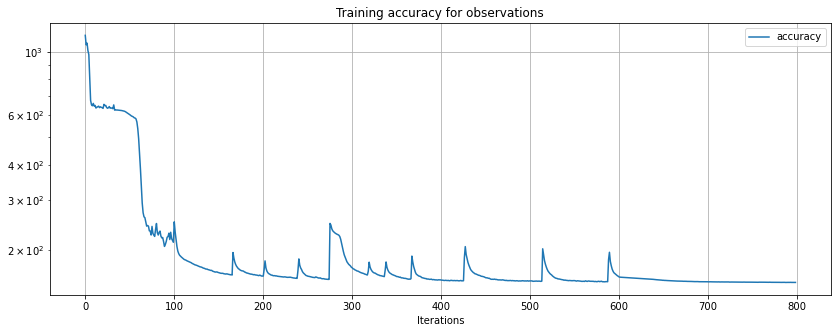

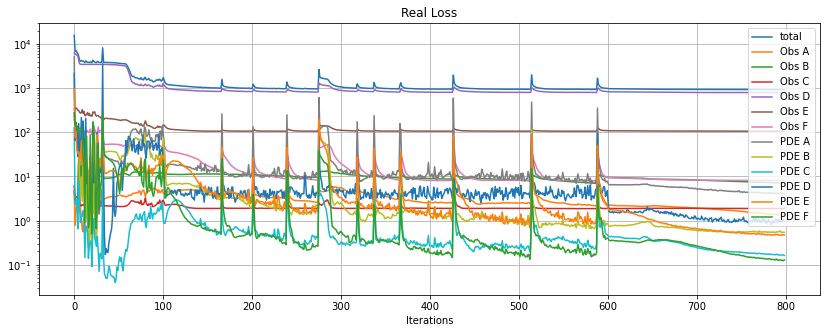

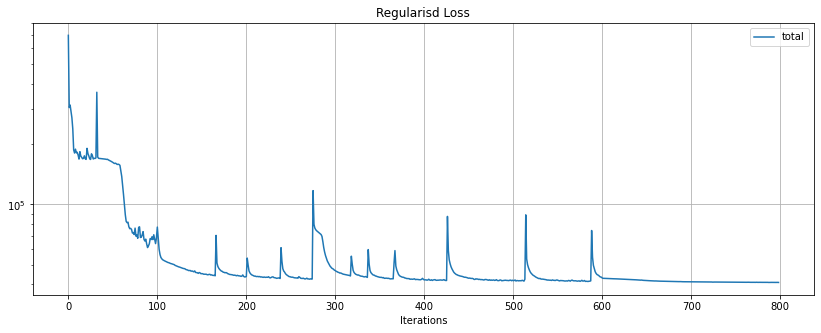

In [21]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3),
                        node_names=node_names, start=0,  yscale='log')

### Run for 200 more epochs to make sure the convergence is so small that is relatively constant

In [22]:
results3 = model.train(
        epochs = 200,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=False,
        sample_gradients=False,
        regularise=False)


Start of epoch 0
Training observations acc over epoch: 153.8324279785
total loss: 929.3761119843, total regularisd loss (sum of batches): 40896.9869384766
obs A loss: 1.3012268208, pde A loss: 4.0237238929
obs B loss: 7.0261710137, pde B loss: 0.5383190159
obs C loss: 1.8698054235, pde C loss: 0.1607211570
obs D loss: 798.6647396088, pde D loss: 1.0672367206
obs E loss: 106.0760610104, pde E loss: 0.4691079054
obs F loss: 8.0564619601, pde F loss: 0.1225448246
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 70.19s

Start of epoch 10
Training observations acc over epoch: 153.8265380859
total loss: 929.4687633514, total regularisd loss (sum of batches): 40897.4481201172
obs A loss: 1.2435236722, p

Training observations acc over epoch: 153.0168457031
total loss: 923.6166439056, total regularisd loss (sum of batches): 40634.1397705078
obs A loss: 0.8374198526, pde A loss: 3.4984380528
obs B loss: 4.8545579240, pde B loss: 0.5038538631
obs C loss: 1.8650534917, pde C loss: 0.1292859977
obs D loss: 796.6612367630, pde D loss: 0.9166045524
obs E loss: 105.9374499321, pde E loss: 0.3865683363
obs F loss: 7.9450771511, pde F loss: 0.0810905083
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 646.88s

Start of epoch 110
Training observations acc over epoch: 152.8710632324
total loss: 922.7226963043, total regularisd loss (sum of batches): 40596.7324218750
obs A loss: 0.8123221211, pde A loss: 3.450

### For 200 epchos, the loss reduction was about 1 unit, which make sense, since the learning rate is $10^{-5}$. And increasing the learning rate keeps it at the plateau with spikes.

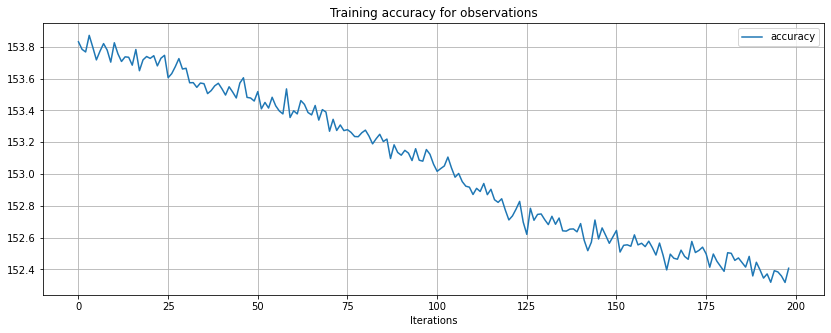

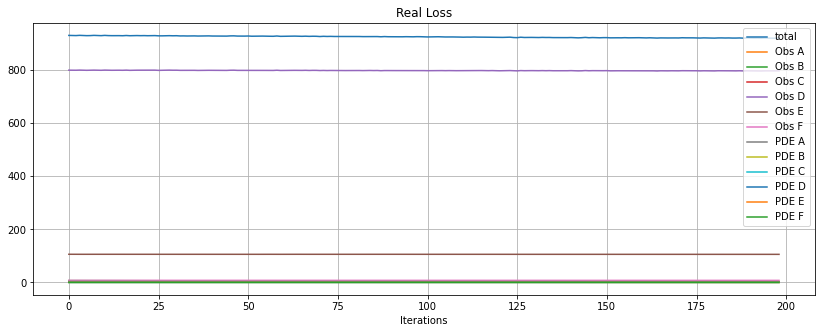

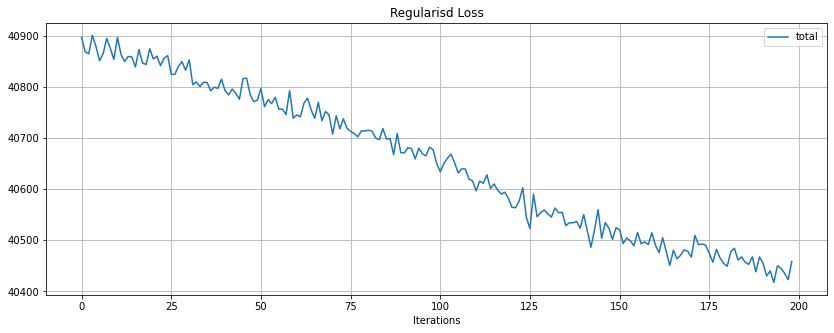

In [24]:
plot_result_multi_nodes(merge_dict_multi_nodes(results3),
                        node_names=node_names, start=0,  yscale='linear')